In [ ]:
# データのダウンロード
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
! unzip /content/NewsAggregatorDataset.zip

# pandasのインストールとインポート
! pip install pandas
import pandas as pd

--2022-01-30 15:26:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  30.7MB/s    in 0.9s    

2022-01-30 15:26:34 (30.7 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  /content/NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


### データ構成
ID　TITLE　URL　PUBLISHER　CATEGORY　STORY　HOSTNAME　TIMESTAMP

In [ ]:
# data読み込み
df = pd.read_csv('/content/newsCorpora.csv', sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
# 記事の中身を確認
df.head(4)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793


In [ ]:
# ============
# 50. データの入手・整形
# ============
from sklearn.model_selection import train_test_split

# df.locは単独および複数の要素の値を選択、取得、変更が可能
# isinはbool型を返す
df1 = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割 stratifyを設定することで訓練データとテストデータの指定した中身の割合を同じにすることができる
train, temp = train_test_split(df1, test_size=0.2, shuffle=True, random_state=0, stratify=df1['CATEGORY'])
test, valid = train_test_split(temp, test_size=0.5, shuffle=True, random_state=0, stratify=temp['CATEGORY'])

# データの保存
train.to_csv('train.txt', sep="\t", index=False)
test.to_csv('test.txt', sep="\t", index=False)
valid.to_csv('valid.txt', sep="\t", index=False)

print(train['CATEGORY'].value_counts())
print(valid['CATEGORY'].value_counts())
print(test['CATEGORY'].value_counts())

b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64


In [ ]:
# ============
# 51. 特徴量抽出
# ============

from pandas.core.internals.managers import T
import string
import re

def preprocessing(text):
    # str.maketrans()は変換のためのテーブルを作成
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(table)              # 記号をスペースに置換
    text = text.lower()                       # 文字種の統一
    text = re.sub('[0-9]+', '0', text)        # 数字の置き換え

    return text

# データの再結合
df = pd.concat([train, valid, test], axis=0)
df.reset_index(drop=True, inplace=True)  # indexを振りなおす

# 前処理の実施
df['TITLE'] = df['TITLE'].map(lambda x: preprocessing(x))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 目的変数の格納
t_data = df["CATEGORY"]

# TITLEの格納
x_data = df["TITLE"]

# TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=3000) 

# 特徴量抽出
x_data = vectorizer.fit_transform(x_data)
x_data = pd.DataFrame(x_data.toarray(), columns=vectorizer.get_feature_names())

# データ分割
x_train, x_val, t_train, t_val = train_test_split(x_data, t_data, test_size=0.2, shuffle=False, stratify=None)
x_val, x_test, t_val, t_test = train_test_split(x_val, t_val, test_size=0.5, shuffle=False, stratify=None)

print("訓練用：{} {}".format(x_train.shape, t_train.shape))
print("検証用：{} {}".format(x_val.shape, t_val.shape))
print("評価用：{} {}".format(x_test.shape, t_test.shape))

# データの保存
x_train.to_csv('train.feature.txt', sep='\t', index=False)
x_val.to_csv('valid.feature.txt', sep='\t', index=False)
x_test.to_csv('test.feature.txt', sep='\t', index=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


訓練用：(10672, 3000) (10672,)
検証用：(1334, 3000) (1334,)
評価用：(1334, 3000) (1334,)


In [ ]:
# ============
# 52. 学習
# ============
from sklearn.linear_model import LogisticRegression

# モデルの学習
classifier = LogisticRegression(random_state=123, max_iter=10000)
classifier.fit(x_train, t_train)

LogisticRegression(max_iter=10000, random_state=123)

In [ ]:
# ============
# 53. 予測
# ============
# 学習データの予測
train_pred = classifier.predict(x_train)

# 評価データの予測
test_pred = classifier.predict(x_test)

In [ ]:
# ============
# 54. 正解率の計測
# ============
from sklearn.metrics import accuracy_score

# 学習データの正解率の計測
train_acc = accuracy_score(t_train, train_pred)
print("Train accuracy = %1.3f" % train_acc)

# 評価データの正解率の計測
test_acc = accuracy_score(t_test, test_pred)
print("Test accuracy = %1.3f" % test_acc)

Train accuracy = 0.934
Test accuracy = 0.873


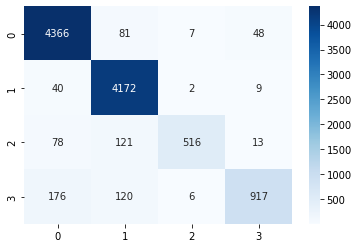

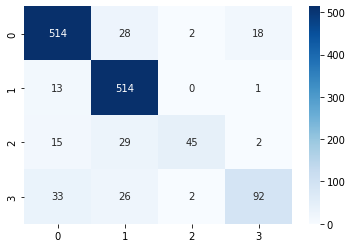

In [ ]:
# ============
# 55. 混同行列の作成
# ============
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 学習データ
train_cm = confusion_matrix(t_train, train_pred)
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt="d")
plt.show()

# 評価データ
test_cm = confusion_matrix(t_test, test_pred)
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt="d")
plt.show()

In [ ]:
# ============
# 56. 適合率、再現率、F1スコアの計測
# ============
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def calculate_scores(y_true, y_pred):
  # 適合率：予測で正例だった予測全体のうち、正解だった割合
  precision = precision_score(t_test, test_pred, average=None, labels=['b', 'e', 't', 'm'])  # Noneを指定するとクラスごとの精度をndarrayで返す
  precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))  # 末尾にマイクロ平均を追加
  precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))  # 末尾にマクロ平均を追加

  # 再現率：
  recall = recall_score(t_test, test_pred, average=None, labels=['b', 'e', 't', 'm'])
  recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
  recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

  # F1スコア
  f1 = f1_score(t_test, test_pred, average=None, labels=['b', 'e', 't', 'm'])
  f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
  f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

  # 結果を結合してデータフレーム化
  scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

  return scores

calculate_scores(t_test, test_pred)

,適合率,再現率,F1スコア
b,0.893913,0.914591,0.904134
e,0.860972,0.973485,0.913778
t,0.814159,0.601307,0.691729
m,0.918367,0.494505,0.642857
マイクロ平均,0.873313,0.873313,0.873313
マクロ平均,0.871853,0.745972,0.788124


In [ ]:
# ============
# 57. 特徴量の重みの確認
# ============
features = x_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(classifier.classes_, classifier.coef_):
  print(f'【カテゴリ】{c}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
  worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
  display(pd.concat([best10, worst10], axis=0))
  print('\n')

【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,fed,bank,stocks,ecb,china,euro,ukraine,yellen,oil,obamacare
重要度下位,and,ebola,the,video,she,her,microsoft,apple,facebook,star




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,kardashian,chris,she,her,kim,miley,cyrus,movie,thrones,paul
重要度下位,update,us,google,china,gm,study,ceo,facebook,apple,says




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,study,fda,cancer,mers,drug,cases,cdc,could,health
重要度下位,gm,facebook,apple,climate,ceo,bank,google,deal,sales,twitter




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,apple,microsoft,climate,nasa,gm,tesla,fcc,heartbleed
重要度下位,stocks,fed,shares,cancer,her,percent,ukraine,thrones,american,ecb


In [ ]:
# ============
# 58. 正則化パラメータの変更
# ============
result = []
# 10^-5 から 10^4
for C in np.logspace(-5, 4, 10, base=10): 
  # モデルの学習
  classifier = LogisticRegression(random_state=123, max_iter=10000, C=C)
  classifier.fit(x_train, t_train)

  # 予測値の取得
  train_pred = classifier.predict(x_train)
  valid_pred = classifier.predict(x_val)
  test_pred = classifier.predict(x_test)

  # 正解率の算出
  train_accuracy = accuracy_score(t_train, train_pred)
  valid_accuracy = accuracy_score(t_val, valid_pred)
  test_accuracy = accuracy_score(t_test, test_pred)

  # 結果の格納
  result.append([C, train_accuracy, valid_accuracy, test_accuracy])

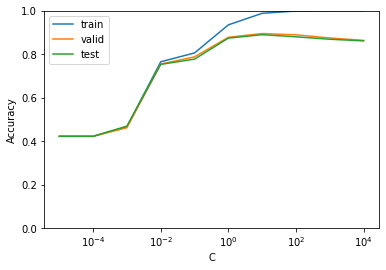

In [ ]:
# 視覚化
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

In [ ]:
# ============
# 59. ハイパーパラメータの探索
# ============
def train_model(x_train, y_train, x_val, y_val):
    best_c, best_tol, best_score = 0, 0, 0
    for c in [0.001, 0.01, 0.1, 0.5, 1, 10, 100]:
        for tol in [0.00001, 0.0001, 0.001, 0.1, 0.5, 1]:
            classifier = LogisticRegression(C=c, tol=tol, max_iter=10000, random_state=123)
            classifier.fit(x_train, t_train)
            val_acc = accuracy_score(t_val, classifier.predict(x_val))
            if best_score < val_acc:
                best_score = val_acc
                best_c = c
                best_tol = tol
            print("Validation accuracy = %1.3f\tC = %s\t tol = %s" % (val_acc, str(c), str(tol)))
    print("Best parameter: C = %s \ttol = %s" % (str(best_c), str(best_tol)))
    return best_c, best_tol
best_c, best_tol = train_model(x_train, t_train, x_val, t_val)

Validation accuracy = 0.461	C = 0.001	 tol = 1e-05
Validation accuracy = 0.461	C = 0.001	 tol = 0.0001
Validation accuracy = 0.461	C = 0.001	 tol = 0.001
Validation accuracy = 0.461	C = 0.001	 tol = 0.1
Validation accuracy = 0.461	C = 0.001	 tol = 0.5
Validation accuracy = 0.461	C = 0.001	 tol = 1
Validation accuracy = 0.754	C = 0.01	 tol = 1e-05
Validation accuracy = 0.754	C = 0.01	 tol = 0.0001
Validation accuracy = 0.754	C = 0.01	 tol = 0.001
Validation accuracy = 0.754	C = 0.01	 tol = 0.1
Validation accuracy = 0.754	C = 0.01	 tol = 0.5
Validation accuracy = 0.754	C = 0.01	 tol = 1
Validation accuracy = 0.787	C = 0.1	 tol = 1e-05
Validation accuracy = 0.787	C = 0.1	 tol = 0.0001
Validation accuracy = 0.787	C = 0.1	 tol = 0.001
Validation accuracy = 0.787	C = 0.1	 tol = 0.1
Validation accuracy = 0.787	C = 0.1	 tol = 0.5
Validation accuracy = 0.787	C = 0.1	 tol = 1
Validation accuracy = 0.865	C = 0.5	 tol = 1e-05
Validation accuracy = 0.865	C = 0.5	 tol = 0.0001
Validation accuracy = 

In [ ]:
# 評価データの正解率

# 学習
classifier = LogisticRegression(C=10, tol=1, max_iter=10000, random_state=123)
classifier.fit(x_train, t_train)

# 正解率の計算
test_accuracy = accuracy_score(t_test, classifier.predict(x_test))
print("Test accuracy = %1.3f" % test_accuracy)

Test accuracy = 0.893
